<a href="https://colab.research.google.com/github/JSKimGitHub/real_time_driving_predictor/blob/main/%EB%A6%AC%ED%97%88%EC%84%A4__2_%EA%B2%B0%EA%B3%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모델 설정

In [91]:
!pip install opencv-python numpy matplotlib ultralytics

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
import pandas as pd

file_path = '/content/drive/MyDrive/towtruck_8_results.csv'
file_path2 = '/content/drive/MyDrive/Uturn_7_dlabeled.csv'
file_path3 = '/content/drive/MyDrive/driving_11_dlabeled.csv'
file_path4 = '/content/drive/MyDrive/driving_12_dlabeled.csv'

# CSV 파일을 DataFrame으로 읽어오기
driving11 = pd.read_csv(file_path3)
truck8 = pd.read_csv(file_path)
uturn7 = pd.read_csv(file_path2)
driving12 = pd.read_csv(file_path4)

In [94]:
from ultralytics import YOLO
import cv2
import numpy as np
import os

# YOLOv8 모델 로드
model = YOLO("yolov8n.pt")  # 가장 가벼운 모델

In [95]:
import torch
import torch.nn as nn

class FM_FTRL_Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim=8, k=4):
        super().__init__()
        self.linear = nn.Linear(input_dim, embedding_dim)
        self.V = nn.Parameter(torch.randn(input_dim, k) * 0.01)
        self.embedding_dim = embedding_dim

    def forward(self, x):
        linear_part = self.linear(x)
        fm_interactions = 0.5 * torch.sum(
            (x @ self.V) ** 2 - (x ** 2) @ (self.V ** 2),
            dim=1, keepdim=True
        )
        fm_interactions_expanded = fm_interactions.reshape(-1, 1).expand(-1, self.embedding_dim)
        return linear_part + fm_interactions_expanded

class FM_FTRL_WithClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim=8, k=4):
        super().__init__()
        self.encoder = FM_FTRL_Encoder(input_dim, embedding_dim, k)
        self.classifier = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        embedding = self.encoder(x)
        logits = self.classifier(embedding)
        return torch.sigmoid(logits).squeeze(1), embedding

class RehearsalMemory:
    def __init__(self, max_samples=1000):
        self.max_samples = max_samples
        self.data_buffer = []
        self.label_buffer = []

    def add_samples(self, data, labels):
        """새로운 데이터 샘플을 메모리에 추가"""
        # 데이터를 numpy 배열로 변환하여 저장
        if isinstance(data, torch.Tensor):
            data = data.detach().cpu().numpy()
        if isinstance(labels, torch.Tensor):
            labels = labels.detach().cpu().numpy()

        # 데이터를 메모리에 추가
        for i in range(len(data)):
            self.data_buffer.append(data[i].copy())  # copy()로 깊은 복사
            self.label_buffer.append(labels[i].copy())

        # 최대 샘플 수를 초과하면 오래된 샘플 제거
        if len(self.data_buffer) > self.max_samples:
            self.data_buffer = self.data_buffer[-self.max_samples:]
            self.label_buffer = self.label_buffer[-self.max_samples:]

    def get_rehearsal_batch(self, batch_size=32):
        """재학습용 배치 데이터 반환"""
        if len(self.data_buffer) == 0:
            return None, None

        # 랜덤하게 샘플링
        indices = np.random.choice(len(self.data_buffer),
                                 min(batch_size, len(self.data_buffer)),
                                 replace=False)

        # numpy 배열을 텐서로 변환
        batch_data = torch.tensor(np.array([self.data_buffer[i] for i in indices]), dtype=torch.float32)
        batch_labels = torch.tensor(np.array([self.label_buffer[i] for i in indices]), dtype=torch.float32)

        return batch_data, batch_labels

    def get_all_data(self):
        """모든 저장된 데이터 반환"""
        if len(self.data_buffer) == 0:
            return None, None

        all_data = torch.tensor(np.array(self.data_buffer), dtype=torch.float32)
        all_labels = torch.tensor(np.array(self.label_buffer), dtype=torch.float32)

        return all_data, all_labels


In [96]:
import torch.optim as optim

In [97]:
def preprocess_input(cls_id, conf, dist, area, cx, cy, num_classes=10):
    x = np.zeros(num_classes + 5)
    if 0 <= cls_id < num_classes:
        x[cls_id] = 1.0
    x[num_classes:] = [conf, dist / 100, area / 10000, cx / 1920, cy / 1080]
    return torch.tensor(x, dtype=torch.float32).unsqueeze(0)

def add_noise(x, level=0.1):
    return x + level * torch.randn_like(x)

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLO("yolov8n.pt")  # YOLOv8
input_dim = 10 + 5
fm_model = FM_FTRL_WithClassifier(input_dim)
optimizer = optim.Adam(fm_model.parameters(), lr=1e-3)

# Rehearsal 메모리 초기화
rehearsal_memory = RehearsalMemory(max_samples=900)

fm_model.to(device)
fm_model.train()
loss_fn = nn.MSELoss()

loss_buffer = []
action_buffer = []
measuring_loss = False
video_file_count = 0

#Task1 학습

## driving 11 학습 (라벨 포함)

In [99]:
driving11 = driving11['go_stop_decision']

In [100]:
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
video_path = next(iter(uploaded))

#driving_11.mp4


Saving driving_11.mp4 to driving_11 (1).mp4


In [101]:
cap = cv2.VideoCapture(video_path)

frame_idx = 0
step = 0
measuring_loss = True
task_data = []
task_labels = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1

    result = model(frame)[0]
    h, w, _ = frame.shape
    frame_actions = []

    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        area = (x2 - x1) * (y2 - y1)
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

        x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
        x_noisy = add_noise(x)

        y_pred, emb_orig = fm_model(x)
        _, emb_noisy = fm_model(x_noisy)

        # 첫 번째 태스크는 지도학습
        label = torch.tensor([driving11[frame_idx-1]], dtype=torch.float32).to(device)
        supervised_loss = loss_fn(y_pred, label)

        # 노이즈에 대한 일관성 손실
        consistency_loss = loss_fn(emb_noisy, emb_orig.detach())

        total_loss = supervised_loss + 0.1 * consistency_loss

        if measuring_loss:
            loss_buffer.append(total_loss.item())

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # 태스크 데이터를 메모리에 저장 (numpy 배열로 변환)
        task_data.append(x.detach().cpu().numpy().squeeze(0))
        task_labels.append(label.detach().cpu().numpy().squeeze(0))

        act = int(y_pred.item() >= 0.5)
        frame_actions.append(act)

    final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
    if measuring_loss:
        action_buffer.append(final_act)

cap.release()

# 첫 번째 태스크 데이터를 rehearsal 메모리에 저장
rehearsal_memory.add_samples(task_data, task_labels)

print("First task completed. Data stored in rehearsal memory.")
print("Rehearsal Action Buffer:", action_buffer)
print("Loss Buffer:", loss_buffer)
print(f"Total frames processed: {frame_idx}")


0: 384x640 1 person, 1 car, 1 kite, 210.1ms
Speed: 3.3ms preprocess, 210.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 205.6ms
Speed: 3.2ms preprocess, 205.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 kite, 205.0ms
Speed: 3.2ms preprocess, 205.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 kite, 175.9ms
Speed: 3.1ms preprocess, 175.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 126.1ms
Speed: 3.0ms preprocess, 126.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 130.6ms
Speed: 2.9ms preprocess, 130.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 kite, 128.2ms
Speed: 2.9ms preprocess, 128.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1

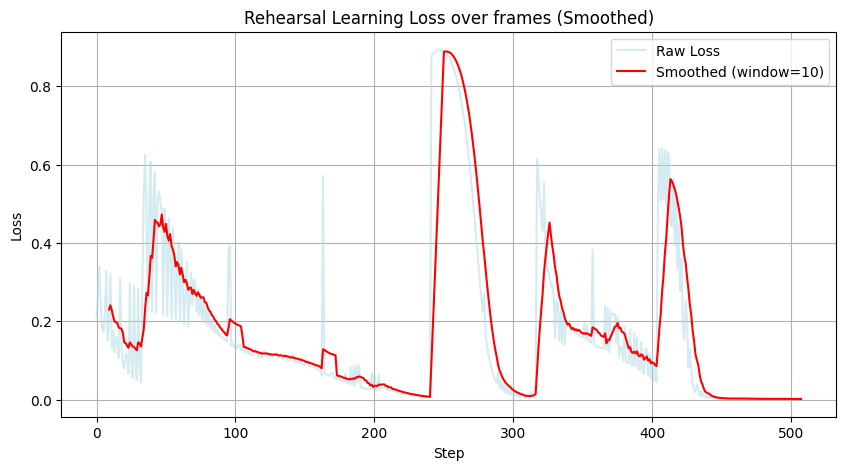

In [102]:
#첫 번째 태스크 손실 시각화
import numpy as np
import matplotlib.pyplot as plt

# 이동평균 함수
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 원본 데이터
plt.figure(figsize=(10, 5))
plt.plot(loss_buffer, color='lightblue', alpha=0.5, label='Raw Loss')

# 이동평균 데이터
smoothed_loss = moving_average(loss_buffer, 10)
plt.plot(range(10-1, len(loss_buffer)), smoothed_loss, color='red', label='Smoothed (window=10)')

plt.title("Rehearsal Learning Loss over frames (Smoothed)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


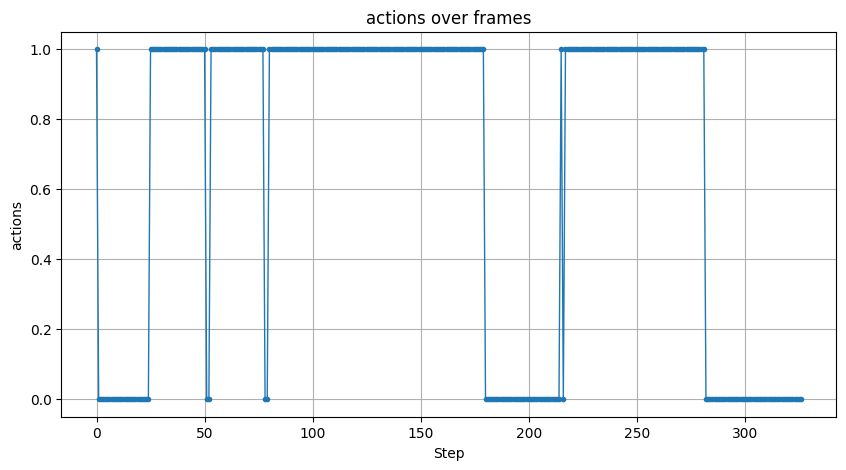

In [103]:
#첫 번째 태스크 액션 시각화
import matplotlib.pyplot as plt

# Loss 변화 시각화
plt.figure(figsize=(10, 5))
plt.plot(action_buffer, marker='o', markersize=3, linewidth=1)
plt.title("actions over frames")
plt.xlabel("Step")
plt.ylabel("actions")
plt.grid(True)
plt.show()

## driving 13 학습 (라벨 미포함)

In [104]:
#두 번째 태스크 학습 (라벨 없이, rehearsal 사용)
#두 번째 비디오 업로드
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
video_path = next(iter(uploaded))

#driving_13

Saving driving_13.mp4 to driving_13 (1).mp4


In [105]:
# ===== 두 번째 태스크 학습 (rehearsal 방식) =====
cap = cv2.VideoCapture(video_path)

frame_idx = 0
step = 0
measuring_loss = True
new_task_data = []
new_task_labels = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    step += 1

    result = model(frame)[0]
    h, w, _ = frame.shape
    frame_actions = []

    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        if conf <= 0.6:
            continue
        else:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            area = (x2 - x1) * (y2 - y1)
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

            x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
            x_noisy = add_noise(x)

            y_pred, emb_orig = fm_model(x)
            _, emb_noisy = fm_model(x_noisy)

            # 노이즈에 대한 일관성 손실
            consistency_loss = loss_fn(emb_noisy, emb_orig.detach())

            # Rehearsal 손실: 이전 태스크 데이터와 함께 학습
            rehearsal_data, rehearsal_labels = rehearsal_memory.get_rehearsal_batch(batch_size=16)
            rehearsal_loss = 0

            if rehearsal_data is not None:
                rehearsal_data = rehearsal_data.to(device)
                rehearsal_labels = rehearsal_labels.to(device)

                # 이전 태스크 데이터에 대한 예측
                rehearsal_preds, _ = fm_model(rehearsal_data)
                rehearsal_loss = loss_fn(rehearsal_preds, rehearsal_labels)

            # 총 손실 = 일관성 손실 + rehearsal 손실
            total_loss = consistency_loss + 0.5 * rehearsal_loss

            if measuring_loss:
                loss_buffer.append(total_loss.item())

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # 새로운 태스크 데이터 저장 (numpy 배열로 변환)
            new_task_data.append(x.detach().cpu().numpy().squeeze(0))
            # 라벨이 없으므로 예측값을 pseudo-label로 사용
            new_task_labels.append(y_pred.detach().cpu().numpy().squeeze(0))

            act = int(y_pred.item() >= 0.5)
            frame_actions.append(act)

    final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
    if measuring_loss:
        action_buffer.append(final_act)

cap.release()

# 새로운 태스크 데이터를 rehearsal 메모리에 추가
rehearsal_memory.add_samples(new_task_data, new_task_labels)

print("Second task completed with rehearsal learning.")
print("Rehearsal Action Buffer:", action_buffer)
print("Loss Buffer:", loss_buffer)
print(f"Rehearsal memory size: {len(rehearsal_memory.data_buffer)}")



0: 384x640 1 car, 1 truck, 135.0ms
Speed: 3.3ms preprocess, 135.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 truck, 473.9ms
Speed: 3.0ms preprocess, 473.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 truck, 130.1ms
Speed: 2.8ms preprocess, 130.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 truck, 127.6ms
Speed: 3.9ms preprocess, 127.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 truck, 136.8ms
Speed: 3.9ms preprocess, 136.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 133.2ms
Speed: 3.0ms preprocess, 133.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 truck, 132.2ms
Speed: 3.0ms preprocess, 132.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 131.7ms
Speed: 3.0ms preprocess, 131.7ms inference, 

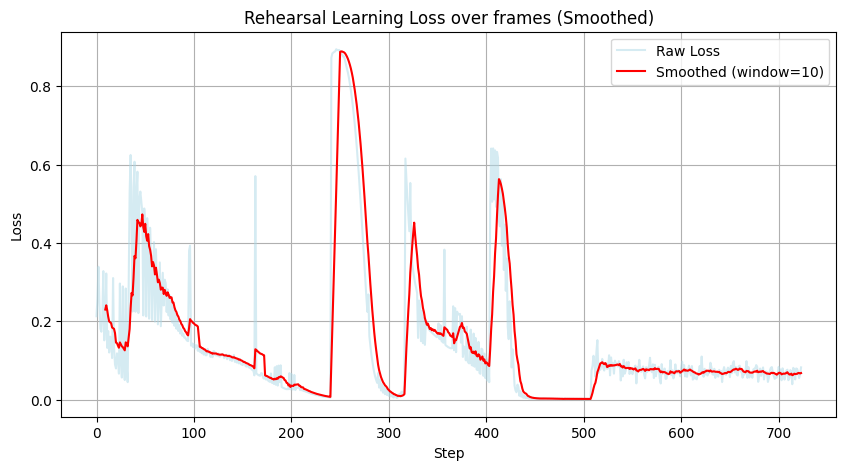

In [106]:
#두 번째 태스크 손실 시각화
import numpy as np
import matplotlib.pyplot as plt

# 이동평균 함수
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 원본 데이터
plt.figure(figsize=(10, 5))
plt.plot(loss_buffer, color='lightblue', alpha=0.5, label='Raw Loss')

# 이동평균 데이터
smoothed_loss = moving_average(loss_buffer, 10)
plt.plot(range(10-1, len(loss_buffer)), smoothed_loss, color='red', label='Smoothed (window=10)')

plt.title("Rehearsal Learning Loss over frames (Smoothed)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

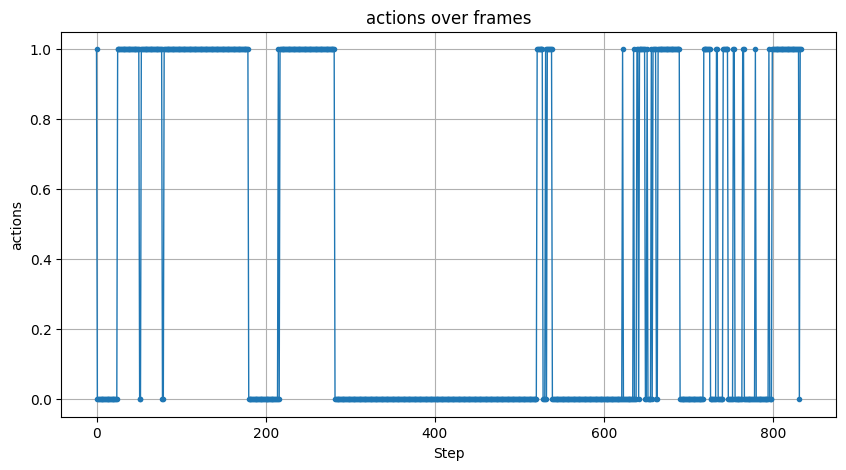

In [107]:
#두 번째 태스크 액션 시각화
import matplotlib.pyplot as plt

# Loss 변화 시각화
plt.figure(figsize=(10, 5))
plt.plot(action_buffer, marker='o', markersize=3, linewidth=1)
plt.title("actions over frames")
plt.xlabel("Step")
plt.ylabel("actions")
plt.grid(True)
plt.show()


#Task1 평가


## driving 12 평가

In [108]:
import numpy as np

def compute_cl_metrics(final_tasks, final_labels, baseline_acc=0.5):
    """
    Continual Learning metrics: IM, FWT, BWT 계산
    - IM (Initial Accuracy): 각 태스크 처음 배운 직후의 평균 정확도
    - FWT (Forward Transfer): baseline 대비 이후 태스크 성능 향상
    - BWT (Backward Transfer): 마지막 학습 후 이전 태스크 성능 변화
    """

    num_tasks = len(final_tasks)
    task_accuracies = []

    # 태스크별 정확도 계산
    for idx in range(num_tasks):
        preds = np.array(final_tasks[idx]).flatten()
        labels = np.array(final_labels[idx]).flatten()

        if preds.size == 0 or labels.size == 0:
            acc = 0.0
        else:
            acc = np.mean(preds == labels)

        task_accuracies.append(acc)

    task_accuracies = np.array(task_accuracies)
    print("Task accuracies:", task_accuracies)

    # IM
    IM = np.mean(task_accuracies) if num_tasks > 0 else 0.0

    # FWT
    if num_tasks > 1:
        FWT = np.mean(task_accuracies[1:] - baseline_acc)
    else:
        FWT = 0.0

    # BWT
    if num_tasks > 1:
        BWT = np.mean(task_accuracies[-1] - task_accuracies[:-1])
    else:
        BWT = 0.0

    return IM, FWT, BWT


In [109]:
#라벨 결과 저장
final_labels = []
final_tasks=[]

In [110]:
#모델 평가 모드 설정
fm_model.eval()
loss_fn = nn.MSELoss()

test_loss_buffer = []
test_action_buffer = []
measuring_loss = False
test_video_file_count = 0


In [111]:
#테스트 비디오 업로드 (driving12)
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
test_video_path = next(iter(uploaded))

Saving driving_12.mp4 to driving_12 (3).mp4


In [112]:
# ===== 테스트용 비디오 불러오기 =====
cap = cv2.VideoCapture(test_video_path)

frame_idx = 0
step = 0
measuring_loss = True

with torch.no_grad():  # 테스트 시 gradient 계산 비활성화
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx += 1
        step += 1

        result = model(frame)[0]
        h, w, _ = frame.shape
        frame_actions = []

        for box in result.boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            area = (x2 - x1) * (y2 - y1)
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

            x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
            x_noisy = add_noise(x)

            y_pred, emb_orig = fm_model(x)
            _, emb_noisy = fm_model(x_noisy)

            # 테스트 시에는 rehearsal 손실만 계산 (학습하지 않음)
            rehearsal_data, rehearsal_labels = rehearsal_memory.get_rehearsal_batch(batch_size=16)
            rehearsal_loss = 0

            if rehearsal_data is not None:
                rehearsal_data = rehearsal_data.to(device)
                rehearsal_labels = rehearsal_labels.to(device)

                rehearsal_preds, _ = fm_model(rehearsal_data)
                rehearsal_loss = loss_fn(rehearsal_preds, rehearsal_labels)

            total_loss = rehearsal_loss

            if measuring_loss:
                test_loss_buffer.append(total_loss.item())

            act = int(y_pred.item() >= 0.5)
            frame_actions.append(act)

        final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
        if measuring_loss:
            test_action_buffer.append(final_act)

cap.release()

print("Test completed with rehearsal evaluation.")
print("Test Action Buffer:", test_action_buffer)
print("Test Loss Buffer:", test_loss_buffer)


0: 384x640 1 person, 1 car, 133.4ms
Speed: 4.7ms preprocess, 133.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 138.0ms
Speed: 3.2ms preprocess, 138.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 135.1ms
Speed: 3.0ms preprocess, 135.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 135.7ms
Speed: 3.8ms preprocess, 135.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 134.5ms
Speed: 4.2ms preprocess, 134.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 151.9ms
Speed: 3.4ms preprocess, 151.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 134.2ms
Speed: 3.6ms preprocess, 134.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bus, 135.3ms
Speed: 3.0ms prepr

In [113]:
#테스트 라벨 설정
test_frame_labels = driving12['go_stop_decision'] # 여기에 driving12, truck8, uturn7을 값을 바꿔가며 넣기

In [114]:
#데이터 타입 및 길이 확인
print(type(test_action_buffer))
print(type(test_frame_labels))
print(len(test_action_buffer))
print(len(test_frame_labels))

<class 'list'>
<class 'pandas.core.series.Series'>
369
369


In [115]:
#결과 저장
final_tasks.append(test_action_buffer)
final_labels.append(test_frame_labels)

In [116]:
# CL 메트릭 계산
IM, FWT, BWT = compute_cl_metrics(final_tasks, final_labels)

print(f"IM (Initial Accuracy): {IM:.5f}")
print(f"FWT (Forward Transfer): {FWT:.5f}")
print(f"BWT (Backward Transfer): {BWT:.5f}")


Task accuracies: [    0.65041]
IM (Initial Accuracy): 0.65041
FWT (Forward Transfer): 0.00000
BWT (Backward Transfer): 0.00000


In [117]:
#Rehearsal 메모리 상태 확인
print(f"Rehearsal memory contains {len(rehearsal_memory.data_buffer)} samples")
print(f"Memory usage: {len(rehearsal_memory.data_buffer)} / {rehearsal_memory.max_samples}")

Rehearsal memory contains 724 samples
Memory usage: 724 / 900


In [118]:
# 저장된 샘플의 일부 확인
if len(rehearsal_memory.data_buffer) > 0:
    sample_data = rehearsal_memory.data_buffer[0]
    sample_label = rehearsal_memory.label_buffer[0]
    print(f"Sample data shape: {sample_data.shape}")
    print(f"Sample label: {sample_label}")

Sample data shape: (15,)
Sample label: 0.0


In [119]:
print(final_tasks)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#Task2 학습

## towtruck 9 학습 (라벨 미포함)

In [120]:
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
train_video_path = next(iter(uploaded))

Saving towtruck_seperation_9.mov to towtruck_seperation_9 (1).mov


In [121]:
#모델 평가 모드 설정
fm_model.train()
loss_fn = nn.MSELoss()

In [122]:
# ===== 세 번째 태스크 학습 (rehearsal 방식) =====
cap = cv2.VideoCapture(train_video_path)

frame_idx = 0
step = 0
measuring_loss = True
new_task_data = []
new_task_labels = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    step += 1

    result = model(frame)[0]
    h, w, _ = frame.shape
    frame_actions = []

    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        if conf <= 0.6:
            continue
        else:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            area = (x2 - x1) * (y2 - y1)
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

            x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
            x_noisy = add_noise(x)

            y_pred, emb_orig = fm_model(x)
            _, emb_noisy = fm_model(x_noisy)

            # 노이즈에 대한 일관성 손실
            consistency_loss = loss_fn(emb_noisy, emb_orig.detach())

            # Rehearsal 손실: 이전 태스크 데이터와 함께 학습
            rehearsal_data, rehearsal_labels = rehearsal_memory.get_rehearsal_batch(batch_size=16)
            rehearsal_loss = 0

            if rehearsal_data is not None:
                rehearsal_data = rehearsal_data.to(device)
                rehearsal_labels = rehearsal_labels.to(device)

                # 이전 태스크 데이터에 대한 예측
                rehearsal_preds, _ = fm_model(rehearsal_data)
                rehearsal_loss = loss_fn(rehearsal_preds, rehearsal_labels)

            # 총 손실 = 일관성 손실 + rehearsal 손실
            total_loss = consistency_loss + 0.5 * rehearsal_loss

            if measuring_loss:
                loss_buffer.append(total_loss.item())

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # 새로운 태스크 데이터 저장 (numpy 배열로 변환)
            new_task_data.append(x.detach().cpu().numpy().squeeze(0))
            # 라벨이 없으므로 예측값을 pseudo-label로 사용
            new_task_labels.append(y_pred.detach().cpu().numpy().squeeze(0))

            act = int(y_pred.item() >= 0.5)
            frame_actions.append(act)

    final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
    if measuring_loss:
        action_buffer.append(final_act)

cap.release()

# 새로운 태스크 데이터를 rehearsal 메모리에 추가
rehearsal_memory.add_samples(new_task_data, new_task_labels)

print("Second task completed with rehearsal learning.")
print("Rehearsal Action Buffer:", action_buffer)
print("Loss Buffer:", loss_buffer)
print(f"Rehearsal memory size: {len(rehearsal_memory.data_buffer)}")



0: 384x640 2 cars, 1 truck, 218.5ms
Speed: 4.6ms preprocess, 218.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 203.7ms
Speed: 8.9ms preprocess, 203.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 2 trucks, 246.6ms
Speed: 4.4ms preprocess, 246.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 203.0ms
Speed: 5.8ms preprocess, 203.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 2 trucks, 202.2ms
Speed: 7.7ms preprocess, 202.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 207.9ms
Speed: 10.5ms preprocess, 207.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 224.2ms
Speed: 4.3ms preprocess, 224.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 217.6ms
Speed: 4.4ms pr

# Task2 평가

## driving12 평가

In [123]:
#라벨 결과 저장
final_labels = []
final_tasks=[]

In [124]:
#모델 평가 모드 설정
fm_model.eval()
loss_fn = nn.MSELoss()

test_loss_buffer = []
test_action_buffer = []
measuring_loss = False
test_video_file_count = 0


In [125]:
#테스트 비디오 업로드 (towtruck 8)
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
test_video_path = next(iter(uploaded))

Saving driving_12.mp4 to driving_12 (4).mp4


In [126]:
# ===== 테스트용 비디오 불러오기 =====
cap = cv2.VideoCapture(test_video_path)

frame_idx = 0
step = 0
measuring_loss = True

with torch.no_grad():  # 테스트 시 gradient 계산 비활성화
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx += 1
        step += 1

        result = model(frame)[0]
        h, w, _ = frame.shape
        frame_actions = []

        for box in result.boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            area = (x2 - x1) * (y2 - y1)
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

            x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
            x_noisy = add_noise(x)

            y_pred, emb_orig = fm_model(x)
            _, emb_noisy = fm_model(x_noisy)

            # 테스트 시에는 rehearsal 손실만 계산 (학습하지 않음)
            rehearsal_data, rehearsal_labels = rehearsal_memory.get_rehearsal_batch(batch_size=16)
            rehearsal_loss = 0

            if rehearsal_data is not None:
                rehearsal_data = rehearsal_data.to(device)
                rehearsal_labels = rehearsal_labels.to(device)

                rehearsal_preds, _ = fm_model(rehearsal_data)
                rehearsal_loss = loss_fn(rehearsal_preds, rehearsal_labels)

            total_loss = rehearsal_loss

            if measuring_loss:
                test_loss_buffer.append(total_loss.item())

            act = int(y_pred.item() >= 0.5)
            frame_actions.append(act)

        final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
        if measuring_loss:
            test_action_buffer.append(final_act)

cap.release()

print("Test completed with rehearsal evaluation.")
print("Test Action Buffer:", test_action_buffer)
print("Test Loss Buffer:", test_loss_buffer)


0: 384x640 1 person, 1 car, 205.4ms
Speed: 4.2ms preprocess, 205.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 192.8ms
Speed: 3.7ms preprocess, 192.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 204.7ms
Speed: 9.5ms preprocess, 204.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 196.9ms
Speed: 3.3ms preprocess, 196.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 216.9ms
Speed: 3.7ms preprocess, 216.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 212.3ms
Speed: 3.3ms preprocess, 212.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 206.0ms
Speed: 7.4ms preprocess, 206.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bus, 223.9ms
Speed: 3.2ms prepr

In [127]:
#테스트 라벨 설정
test_frame_labels = driving12['go_stop_decision'] # 여기에 driving12, truck8, uturn7을 값을 바꿔가며 넣기

In [128]:
#데이터 타입 및 길이 확인
print(type(test_action_buffer))
print(type(test_frame_labels))
print(len(test_action_buffer))
print(len(test_frame_labels))

<class 'list'>
<class 'pandas.core.series.Series'>
369
369


In [129]:
#결과 저장

final_tasks.append(test_action_buffer)
final_labels.append(test_frame_labels)



In [131]:
# CL 메트릭 계산
IM, FWT, BWT = compute_cl_metrics(final_tasks, final_labels)

print(f"IM (Initial Accuracy): {IM:.3f}")
print(f"FWT (Forward Transfer): {FWT:.5f}")
print(f"BWT (Backward Transfer): {BWT:.5f}")


Task accuracies: [    0.65854]
IM (Initial Accuracy): 0.659
FWT (Forward Transfer): 0.00000
BWT (Backward Transfer): 0.00000


In [132]:
#Rehearsal 메모리 상태 확인
print(f"Rehearsal memory contains {len(rehearsal_memory.data_buffer)} samples")
print(f"Memory usage: {len(rehearsal_memory.data_buffer)} / {rehearsal_memory.max_samples}")

Rehearsal memory contains 900 samples
Memory usage: 900 / 900


In [133]:
# 저장된 샘플의 일부 확인
if len(rehearsal_memory.data_buffer) > 0:
    sample_data = rehearsal_memory.data_buffer[0]
    sample_label = rehearsal_memory.label_buffer[0]
    print(f"Sample data shape: {sample_data.shape}")
    print(f"Sample label: {sample_label}")

Sample data shape: (15,)
Sample label: 0.0


In [134]:
print(final_tasks)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## towtruck 8 평가

In [135]:
#라벨 결과 저장
final_labels = []
final_tasks=[]

In [136]:
#모델 평가 모드 설정
fm_model.eval()
loss_fn = nn.MSELoss()

test_loss_buffer = []
test_action_buffer = []
measuring_loss = False
test_video_file_count = 0


In [137]:
#테스트 비디오 업로드 (towtruck 8)
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
test_video_path = next(iter(uploaded))

Saving towtruck_seperation_8.mov to towtruck_seperation_8 (2).mov


In [138]:
# ===== 테스트용 비디오 불러오기 =====
cap = cv2.VideoCapture(test_video_path)

frame_idx = 0
step = 0
measuring_loss = True

with torch.no_grad():  # 테스트 시 gradient 계산 비활성화
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx += 1
        step += 1

        result = model(frame)[0]
        h, w, _ = frame.shape
        frame_actions = []

        for box in result.boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            area = (x2 - x1) * (y2 - y1)
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

            x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
            x_noisy = add_noise(x)

            y_pred, emb_orig = fm_model(x)
            _, emb_noisy = fm_model(x_noisy)

            # 테스트 시에는 rehearsal 손실만 계산 (학습하지 않음)
            rehearsal_data, rehearsal_labels = rehearsal_memory.get_rehearsal_batch(batch_size=16)
            rehearsal_loss = 0

            if rehearsal_data is not None:
                rehearsal_data = rehearsal_data.to(device)
                rehearsal_labels = rehearsal_labels.to(device)

                rehearsal_preds, _ = fm_model(rehearsal_data)
                rehearsal_loss = loss_fn(rehearsal_preds, rehearsal_labels)

            total_loss = rehearsal_loss

            if measuring_loss:
                test_loss_buffer.append(total_loss.item())

            act = int(y_pred.item() >= 0.5)
            frame_actions.append(act)

        final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
        if measuring_loss:
            test_action_buffer.append(final_act)

cap.release()

print("Test completed with rehearsal evaluation.")
print("Test Action Buffer:", test_action_buffer)
print("Test Loss Buffer:", test_loss_buffer)


0: 384x640 2 cars, 1 truck, 139.7ms
Speed: 7.5ms preprocess, 139.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 131.4ms
Speed: 4.3ms preprocess, 131.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 136.3ms
Speed: 3.9ms preprocess, 136.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 136.8ms
Speed: 4.1ms preprocess, 136.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 151.6ms
Speed: 4.1ms preprocess, 151.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 134.3ms
Speed: 4.1ms preprocess, 134.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 136.7ms
Speed: 4.1ms preprocess, 136.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 136.5ms
Speed: 4.2ms prepr

In [139]:
#테스트 라벨 설정
test_frame_labels = truck8['go_stop_decision'] # 여기에 driving12, truck8, uturn7을 값을 바꿔가며 넣기

In [140]:
#데이터 타입 및 길이 확인
print(type(test_action_buffer))
print(type(test_frame_labels))
print(len(test_action_buffer))
print(len(test_frame_labels))

<class 'list'>
<class 'pandas.core.series.Series'>
185
185


In [141]:
#결과 저장
final_tasks.append(test_action_buffer)
final_labels.append(test_frame_labels)

In [142]:
# CL 메트릭 계산
IM, FWT, BWT = compute_cl_metrics(final_tasks, final_labels)

print(f"IM (Initial Accuracy): {IM:.5f}")
print(f"FWT (Forward Transfer): {FWT:.5f}")
print(f"BWT (Backward Transfer): {BWT:.5f}")


Task accuracies: [        0.4]
IM (Initial Accuracy): 0.40000
FWT (Forward Transfer): 0.00000
BWT (Backward Transfer): 0.00000


In [143]:
#Rehearsal 메모리 상태 확인
print(f"Rehearsal memory contains {len(rehearsal_memory.data_buffer)} samples")
print(f"Memory usage: {len(rehearsal_memory.data_buffer)} / {rehearsal_memory.max_samples}")

Rehearsal memory contains 900 samples
Memory usage: 900 / 900


In [144]:
# 저장된 샘플의 일부 확인
if len(rehearsal_memory.data_buffer) > 0:
    sample_data = rehearsal_memory.data_buffer[0]
    sample_label = rehearsal_memory.label_buffer[0]
    print(f"Sample data shape: {sample_data.shape}")
    print(f"Sample label: {sample_label}")

Sample data shape: (15,)
Sample label: 0.0


In [145]:
print(final_tasks)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


# Task3 학습

##Uturn 5 학습 (라벨 미포함)

In [146]:
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출 (Uturn5)
train_video_path = next(iter(uploaded))

Saving Uturn_5.mov to Uturn_5 (1).mov


In [147]:
#모델 평가 모드 설정
fm_model.train()
loss_fn = nn.MSELoss()

In [148]:
# ===== 네 번째 태스크 학습 (rehearsal 방식) =====
cap = cv2.VideoCapture(train_video_path)

frame_idx = 0
step = 0
measuring_loss = True
new_task_data = []
new_task_labels = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    step += 1

    result = model(frame)[0]
    h, w, _ = frame.shape
    frame_actions = []

    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        if conf <= 0.6:
            continue
        else:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            area = (x2 - x1) * (y2 - y1)
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

            x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
            x_noisy = add_noise(x)

            y_pred, emb_orig = fm_model(x)
            _, emb_noisy = fm_model(x_noisy)

            # 노이즈에 대한 일관성 손실
            consistency_loss = loss_fn(emb_noisy, emb_orig.detach())

            # Rehearsal 손실: 이전 태스크 데이터와 함께 학습
            rehearsal_data, rehearsal_labels = rehearsal_memory.get_rehearsal_batch(batch_size=16)
            rehearsal_loss = 0

            if rehearsal_data is not None:
                rehearsal_data = rehearsal_data.to(device)
                rehearsal_labels = rehearsal_labels.to(device)

                # 이전 태스크 데이터에 대한 예측
                rehearsal_preds, _ = fm_model(rehearsal_data)
                rehearsal_loss = loss_fn(rehearsal_preds, rehearsal_labels)

            # 총 손실 = 일관성 손실 + rehearsal 손실
            total_loss = consistency_loss + 0.5 * rehearsal_loss

            if measuring_loss:
                loss_buffer.append(total_loss.item())

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # 새로운 태스크 데이터 저장 (numpy 배열로 변환)
            new_task_data.append(x.detach().cpu().numpy().squeeze(0))
            # 라벨이 없으므로 예측값을 pseudo-label로 사용
            new_task_labels.append(y_pred.detach().cpu().numpy().squeeze(0))

            act = int(y_pred.item() >= 0.5)
            frame_actions.append(act)

    final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
    if measuring_loss:
        action_buffer.append(final_act)

cap.release()

# 새로운 태스크 데이터를 rehearsal 메모리에 추가
rehearsal_memory.add_samples(new_task_data, new_task_labels)

print("Second task completed with rehearsal learning.")
print("Rehearsal Action Buffer:", action_buffer)
print("Loss Buffer:", loss_buffer)
print(f"Rehearsal memory size: {len(rehearsal_memory.data_buffer)}")



0: 384x640 2 cars, 150.2ms
Speed: 3.7ms preprocess, 150.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 135.2ms
Speed: 5.2ms preprocess, 135.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 135.9ms
Speed: 4.7ms preprocess, 135.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 134.1ms
Speed: 4.5ms preprocess, 134.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 135.1ms
Speed: 4.4ms preprocess, 135.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 134.2ms
Speed: 4.3ms preprocess, 134.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 130.3ms
Speed: 4.0ms preprocess, 130.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 149.5ms
Speed: 4.2ms preprocess, 149.5ms inference, 1.2ms postprocess per image at shape (1, 3, 38

#Task3 평가

##driving12 평가

In [149]:
#라벨 결과 저장
final_labels = []
final_tasks=[]

In [150]:
#모델 평가 모드 설정
fm_model.eval()
loss_fn = nn.MSELoss()

test_loss_buffer = []
test_action_buffer = []
measuring_loss = False
test_video_file_count = 0


In [151]:
#테스트 비디오 업로드 (driving12)
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
test_video_path = next(iter(uploaded))

Saving driving_12.mp4 to driving_12 (5).mp4


In [152]:
# ===== 테스트용 비디오 불러오기 =====
cap = cv2.VideoCapture(test_video_path)

frame_idx = 0
step = 0
measuring_loss = True

with torch.no_grad():  # 테스트 시 gradient 계산 비활성화
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx += 1
        step += 1

        result = model(frame)[0]
        h, w, _ = frame.shape
        frame_actions = []

        for box in result.boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            area = (x2 - x1) * (y2 - y1)
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

            x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
            x_noisy = add_noise(x)

            y_pred, emb_orig = fm_model(x)
            _, emb_noisy = fm_model(x_noisy)

            # 테스트 시에는 rehearsal 손실만 계산 (학습하지 않음)
            rehearsal_data, rehearsal_labels = rehearsal_memory.get_rehearsal_batch(batch_size=16)
            rehearsal_loss = 0

            if rehearsal_data is not None:
                rehearsal_data = rehearsal_data.to(device)
                rehearsal_labels = rehearsal_labels.to(device)

                rehearsal_preds, _ = fm_model(rehearsal_data)
                rehearsal_loss = loss_fn(rehearsal_preds, rehearsal_labels)

            total_loss = rehearsal_loss

            if measuring_loss:
                test_loss_buffer.append(total_loss.item())

            act = int(y_pred.item() >= 0.5)
            frame_actions.append(act)

        final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
        if measuring_loss:
            test_action_buffer.append(final_act)

cap.release()

print("Test completed with rehearsal evaluation.")
print("Test Action Buffer:", test_action_buffer)
print("Test Loss Buffer:", test_loss_buffer)


0: 384x640 1 person, 1 car, 213.6ms
Speed: 4.4ms preprocess, 213.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 209.2ms
Speed: 3.2ms preprocess, 209.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 195.1ms
Speed: 9.2ms preprocess, 195.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 188.5ms
Speed: 3.2ms preprocess, 188.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 194.7ms
Speed: 3.1ms preprocess, 194.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 205.9ms
Speed: 3.1ms preprocess, 205.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 211.6ms
Speed: 3.1ms preprocess, 211.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bus, 196.7ms
Speed: 3.2ms prepr

In [153]:
#테스트 라벨 설정
test_frame_labels = driving12['go_stop_decision'] # 여기에 driving12, truck8, uturn7을 값을 바꿔가며 넣기

In [154]:
#데이터 타입 및 길이 확인
print(type(test_action_buffer))
print(type(test_frame_labels))
print(len(test_action_buffer))
print(len(test_frame_labels))

<class 'list'>
<class 'pandas.core.series.Series'>
369
369


In [155]:
#결과 저장
final_tasks.append(test_action_buffer)
final_labels.append(test_frame_labels)

In [156]:
# CL 메트릭 계산
IM, FWT, BWT = compute_cl_metrics(final_tasks, final_labels)

print(f"IM (Initial Accuracy): {IM:.5f}")
print(f"FWT (Forward Transfer): {FWT:.5f}")
print(f"BWT (Backward Transfer): {BWT:.5f}")


Task accuracies: [    0.67209]
IM (Initial Accuracy): 0.67209
FWT (Forward Transfer): 0.00000
BWT (Backward Transfer): 0.00000


In [157]:
#Rehearsal 메모리 상태 확인
print(f"Rehearsal memory contains {len(rehearsal_memory.data_buffer)} samples")
print(f"Memory usage: {len(rehearsal_memory.data_buffer)} / {rehearsal_memory.max_samples}")

Rehearsal memory contains 900 samples
Memory usage: 900 / 900


In [159]:
# 저장된 샘플의 일부 확인
if len(rehearsal_memory.data_buffer) > 0:
    sample_data = rehearsal_memory.data_buffer[0]
    sample_label = rehearsal_memory.label_buffer[0]
    print(f"Sample data shape: {sample_data.shape}")
    print(f"Sample label: {sample_label}")

Sample data shape: (15,)
Sample label: 0.0


In [160]:
print(final_tasks)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

##towtruck8 평가

In [161]:
#라벨 결과 저장
final_labels = []
final_tasks=[]


In [162]:
#모델 평가 모드 설정
fm_model.eval()
loss_fn = nn.MSELoss()

test_loss_buffer = []
test_action_buffer = []
measuring_loss = False
test_video_file_count = 0


In [163]:
#테스트 비디오 업로드 (towtruck 8)
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
test_video_path = next(iter(uploaded))

Saving towtruck_seperation_8.mov to towtruck_seperation_8 (3).mov


In [164]:
# ===== 테스트용 비디오 불러오기 =====
cap = cv2.VideoCapture(test_video_path)

frame_idx = 0
step = 0
measuring_loss = True

with torch.no_grad():  # 테스트 시 gradient 계산 비활성화
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx += 1
        step += 1

        result = model(frame)[0]
        h, w, _ = frame.shape
        frame_actions = []

        for box in result.boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            area = (x2 - x1) * (y2 - y1)
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

            x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
            x_noisy = add_noise(x)

            y_pred, emb_orig = fm_model(x)
            _, emb_noisy = fm_model(x_noisy)

            # 테스트 시에는 rehearsal 손실만 계산 (학습하지 않음)
            rehearsal_data, rehearsal_labels = rehearsal_memory.get_rehearsal_batch(batch_size=16)
            rehearsal_loss = 0

            if rehearsal_data is not None:
                rehearsal_data = rehearsal_data.to(device)
                rehearsal_labels = rehearsal_labels.to(device)

                rehearsal_preds, _ = fm_model(rehearsal_data)
                rehearsal_loss = loss_fn(rehearsal_preds, rehearsal_labels)

            total_loss = rehearsal_loss

            if measuring_loss:
                test_loss_buffer.append(total_loss.item())

            act = int(y_pred.item() >= 0.5)
            frame_actions.append(act)

        final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
        if measuring_loss:
            test_action_buffer.append(final_act)

cap.release()

print("Test completed with rehearsal evaluation.")
print("Test Action Buffer:", test_action_buffer)
print("Test Loss Buffer:", test_loss_buffer)


0: 384x640 2 cars, 1 truck, 196.2ms
Speed: 4.5ms preprocess, 196.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 214.2ms
Speed: 6.4ms preprocess, 214.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 203.6ms
Speed: 4.3ms preprocess, 203.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 201.8ms
Speed: 6.3ms preprocess, 201.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 209.6ms
Speed: 4.3ms preprocess, 209.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 130.8ms
Speed: 4.5ms preprocess, 130.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 134.9ms
Speed: 4.3ms preprocess, 134.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 150.1ms
Speed: 4.6ms prepr

In [165]:
#테스트 라벨 설정
test_frame_labels = truck8['go_stop_decision'] # 여기에 driving12, truck8, uturn7을 값을 바꿔가며 넣기

In [166]:
#데이터 타입 및 길이 확인
print(type(test_action_buffer))
print(type(test_frame_labels))
print(len(test_action_buffer))
print(len(test_frame_labels))

<class 'list'>
<class 'pandas.core.series.Series'>
185
185


In [167]:
#결과 저장
final_tasks.append(test_action_buffer)
final_labels.append(test_frame_labels)

In [168]:
# CL 메트릭 계산
IM, FWT, BWT = compute_cl_metrics(final_tasks, final_labels)

print(f"IM (Initial Accuracy): {IM:.5f}")
print(f"FWT (Forward Transfer): {FWT:.5f}")
print(f"BWT (Backward Transfer): {BWT:.5f}")


Task accuracies: [    0.41081]
IM (Initial Accuracy): 0.41081
FWT (Forward Transfer): 0.00000
BWT (Backward Transfer): 0.00000


In [169]:
#Rehearsal 메모리 상태 확인
print(f"Rehearsal memory contains {len(rehearsal_memory.data_buffer)} samples")
print(f"Memory usage: {len(rehearsal_memory.data_buffer)} / {rehearsal_memory.max_samples}")

Rehearsal memory contains 900 samples
Memory usage: 900 / 900


In [170]:
# 저장된 샘플의 일부 확인
if len(rehearsal_memory.data_buffer) > 0:
    sample_data = rehearsal_memory.data_buffer[0]
    sample_label = rehearsal_memory.label_buffer[0]
    print(f"Sample data shape: {sample_data.shape}")
    print(f"Sample label: {sample_label}")

Sample data shape: (15,)
Sample label: 0.0


In [171]:
print(final_tasks)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


##Uturn7 평가

In [172]:
#라벨 결과 저장
final_labels = []
final_tasks=[]


In [173]:
#모델 평가 모드 설정
fm_model.eval()
loss_fn = nn.MSELoss()

test_loss_buffer = []
test_action_buffer = []
measuring_loss = False
test_video_file_count = 0


In [174]:
#테스트 비디오 업로드 (Uturn 7)
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
test_video_path = next(iter(uploaded))

Saving Uturn_7.mov to Uturn_7 (1).mov


In [175]:
# ===== 테스트용 비디오 불러오기 =====
cap = cv2.VideoCapture(test_video_path)

frame_idx = 0
step = 0
measuring_loss = True

with torch.no_grad():  # 테스트 시 gradient 계산 비활성화
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx += 1
        step += 1

        result = model(frame)[0]
        h, w, _ = frame.shape
        frame_actions = []

        for box in result.boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            area = (x2 - x1) * (y2 - y1)
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

            x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
            x_noisy = add_noise(x)

            y_pred, emb_orig = fm_model(x)
            _, emb_noisy = fm_model(x_noisy)

            # 테스트 시에는 rehearsal 손실만 계산 (학습하지 않음)
            rehearsal_data, rehearsal_labels = rehearsal_memory.get_rehearsal_batch(batch_size=16)
            rehearsal_loss = 0

            if rehearsal_data is not None:
                rehearsal_data = rehearsal_data.to(device)
                rehearsal_labels = rehearsal_labels.to(device)

                rehearsal_preds, _ = fm_model(rehearsal_data)
                rehearsal_loss = loss_fn(rehearsal_preds, rehearsal_labels)

            total_loss = rehearsal_loss

            if measuring_loss:
                test_loss_buffer.append(total_loss.item())

            act = int(y_pred.item() >= 0.5)
            frame_actions.append(act)

        final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
        if measuring_loss:
            test_action_buffer.append(final_act)

cap.release()

print("Test completed with rehearsal evaluation.")
print("Test Action Buffer:", test_action_buffer)
print("Test Loss Buffer:", test_loss_buffer)


0: 384x640 1 person, 2 cars, 1 truck, 155.0ms
Speed: 5.1ms preprocess, 155.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 129.3ms
Speed: 4.0ms preprocess, 129.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 129.3ms
Speed: 4.2ms preprocess, 129.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 129.8ms
Speed: 4.3ms preprocess, 129.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 truck, 127.2ms
Speed: 4.2ms preprocess, 127.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 truck, 129.9ms
Speed: 4.8ms preprocess, 129.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 truck, 127.7ms
Speed: 4.3ms preprocess, 127.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 

In [176]:
#테스트 라벨 설정
test_frame_labels = uturn7['go_stop_decision'] # 여기에 driving12, truck8, uturn7을 값을 바꿔가며 넣기

In [177]:
#데이터 타입 및 길이 확인
print(type(test_action_buffer))
print(type(test_frame_labels))
print(len(test_action_buffer))
print(len(test_frame_labels))

<class 'list'>
<class 'pandas.core.series.Series'>
134
134


In [178]:
#결과 저장
final_tasks.append(test_action_buffer)
final_labels.append(test_frame_labels)

In [179]:
# CL 메트릭 계산
IM, FWT, BWT = compute_cl_metrics(final_tasks, final_labels)

print(f"IM (Initial Accuracy): {IM:.5f}")
print(f"FWT (Forward Transfer): {FWT:.5f}")
print(f"BWT (Backward Transfer): {BWT:.5f}")


Task accuracies: [    0.76119]
IM (Initial Accuracy): 0.76119
FWT (Forward Transfer): 0.00000
BWT (Backward Transfer): 0.00000


In [180]:
#Rehearsal 메모리 상태 확인
print(f"Rehearsal memory contains {len(rehearsal_memory.data_buffer)} samples")
print(f"Memory usage: {len(rehearsal_memory.data_buffer)} / {rehearsal_memory.max_samples}")

Rehearsal memory contains 900 samples
Memory usage: 900 / 900


In [181]:
# 저장된 샘플의 일부 확인
if len(rehearsal_memory.data_buffer) > 0:
    sample_data = rehearsal_memory.data_buffer[0]
    sample_label = rehearsal_memory.label_buffer[0]
    print(f"Sample data shape: {sample_data.shape}")
    print(f"Sample label: {sample_label}")

Sample data shape: (15,)
Sample label: 0.0
